# First case

In [1]:
import festim as F
import numpy as np
import fenics as f

encl_vol = 5.20e-11  # m3  same
encl_surf = 2.16e-6  # m2  same
l = 3.3e-5  # m same
R = 8.314  # same
avogadro = 6.022e23  # mol-1  same
temperature = 2373  # K  same
initial_pressure = 1e6  # Pa  same
solubility = 7.244e22 / temperature  # H/m3/Pa  # same
diffusivity = 2.6237e-11  # m2/s  almost same


def henrys_law(T, S_0, E_S, pressure):
    S = S_0 * f.exp(-E_S / F.k_B / T)
    return S * pressure


class PressureExport(F.DerivedQuantity):
    def __init__(self, **kwargs):
        super().__init__(field="solute", **kwargs)
        self.title = "enclosure_pressure"
        self.data = []

    def compute(self):
        return float(left_bc.pressure)


class CustomHenrysBC(F.HenrysBC):
    def create_expression(self, T):
        value_BC = F.BoundaryConditionExpression(
            T,
            henrys_law,
            S_0=self.H_0,
            E_S=self.E_H,
            pressure=self.pressure,
        )
        self.expression = value_BC
        self.sub_expressions = [self.pressure]


class CustomSimulation(F.Simulation):
    def iterate(self):
        super().iterate()
        # Update pressure based on flux
        left_flux_val = left_flux.compute()
        old_pressure = float(left_bc.pressure)
        new_pressure = (
            old_pressure
            - (left_flux_val * encl_surf / encl_vol * R * self.T.T(0) / avogadro)
            * self.dt.value
        )
        left_bc.pressure.assign(new_pressure)


my_model = CustomSimulation()

vertices = np.linspace(0, l, 50)

my_model.mesh = F.MeshFromVertices(vertices)

my_model.materials = F.Material(
    id=1,
    D_0=diffusivity,
    E_D=0,
)

left_bc = CustomHenrysBC(
    surfaces=1, H_0=solubility, E_H=0, pressure=f.Constant(initial_pressure)
)

my_model.boundary_conditions = [
    left_bc,
    F.DirichletBC(surfaces=2, value=0, field="solute"),
]

my_model.T = F.Temperature(temperature)

my_model.settings = F.Settings(
    absolute_tolerance=1e8,
    relative_tolerance=1e-10,
    final_time=140,
)

left_flux = F.HydrogenFlux(surface=1)
right_flux = F.HydrogenFlux(surface=2)
pressure_export = PressureExport()
derived_quantities = F.DerivedQuantities([left_flux, right_flux, pressure_export])

my_model.exports = [
    # F.XDMFExport("solute", filename="enclosure/mobile.xdmf", checkpoint=False),
    derived_quantities,
]

my_model.dt = F.Stepsize(initial_value=0.05)

# my_model.log_level = 10

my_model.initialise()
my_model.run()
print(f"final pressure is {float(left_bc.pressure)}")

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/exports/derived_quantities/derived_quantities.py:49: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        1.4e+02 s    Ellapsed time so far: 7.8 s
final pressure is 28781.97122710641


/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/materials/materials.py:31: DeprecationWarning: The materials attribute will be deprecated in a future release, please use festim.Materials as a list instead
  warnings.warn(
/home/remidm/miniconda3/envs/vv-festim-report-env/lib/python3.11/site-packages/festim/materials/materials.py:31: DeprecationWarning: The materials attribute will be deprecated in a future release, please use festim.Materials as a list instead
  warnings.warn(


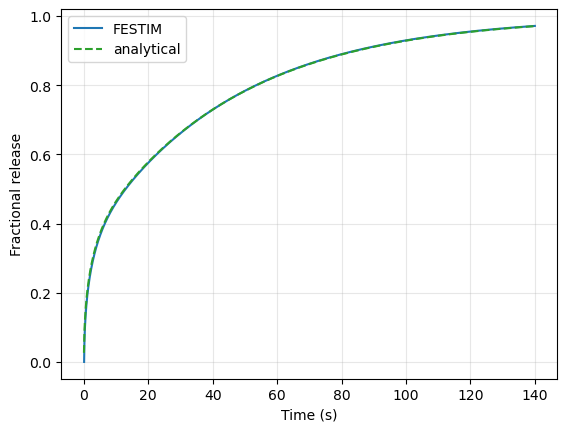

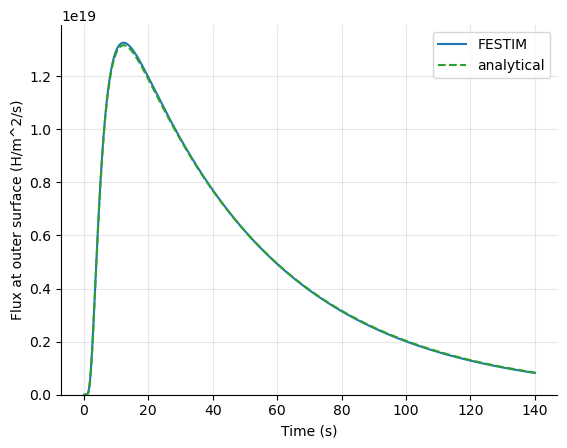

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/28766692/how-to-find-the-intersection-of-two-graphs/28766902#28766902

k = 1.38065e-23  # J/mol Boltzmann constant


def get_roots(L, l, alpha_max, step=0.0001):
    """Gets the roots of alpha = L / tan(alpha * l)

    Args:
        L (float): parameter L
        l (float): parameter l
        alpha_max (float): the maximum alpha to consider
        step (float, optional): the step discretising alphas.
            The smaller the step, the more accurate the roots.
            Defaults to 0.0001.

    Returns:
        np.array: array of roots
    """
    alphas = np.arange(0, alpha_max, step=step)[1:]

    f = alphas

    g = L / np.tan(alphas * l)

    # plt.plot(alphas, f, "-")
    # plt.plot(alphas, g, "-")

    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()

    # remove one every other idx
    idx = idx[::2]
    # plt.plot(alphas[idx], f[idx], "ro")
    # plt.show()
    roots = alphas[idx]
    return roots


def get_roots_bis(L, alpha_max, step=0.0001):
    """Gets the roots of alpha = L / tan(alpha)

    Args:
        L (float): parameter L
        alpha_max (float): the maximum alpha to consider
        step (float, optional): the step discretising alphas.
            The smaller the step, the more accurate the roots.
            Defaults to 0.0001.

    Returns:
        np.array: array of roots
    """
    alphas = np.arange(0, alpha_max, step=step)[1:]

    f = alphas

    g = L / np.tan(alphas)

    plt.plot(alphas, f, "-")
    plt.plot(alphas, g, "-")

    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()

    # remove one every other idx
    idx = idx[::2]
    plt.plot(alphas[idx], f[idx], "ro")
    plt.show()
    roots = alphas[idx]
    return roots


def analytical_expression_fractional_release_TMAP7(t, P_0, D, S, V, T, A, l):
    """
    FR = 1 - P(t) / P_0
    where P(t) is the pressure at time t and P_0 is the initial pressure

    Reference: https://doi.org/10.13182/FST05-A967 (Equation 4)
    Note: in the report, the expression of FR is given as P(T)/P_0, but it shown as 1 - P(t)/P_0 in the graph (Figure 1)

    Args:
        t (float, ndarray): time (s)
        P_0 (float): initial presure (Pa)
        D (float): diffusivity (m2/s)
        S (float): solubility (H/m3/Pa)
        V (float): enclosure volume (m3)
        T (float): temperature (K)
        A (float): enclosure surface area (m2)
        l (float): slab length (m)
    """
    L = S * T * A * k / V

    roots = get_roots(L=L, l=l, alpha_max=1e6, step=1)
    roots = roots[:, np.newaxis]
    summation = np.exp(-(roots**2) * D * t) / (l * (roots**2 + L**2) + L)
    summation = np.sum(summation, axis=0)

    pressure = 2 * P_0 * L * summation
    fractional_release = 1 - pressure / P_0
    return fractional_release


# taken from https://mooseframework.inl.gov/TMAP8/verification/ver-1a.html#longhurst1992verification
def analytical_expression_fractional_release_TMAP8(t, D, S, V, T, A, l):
    """
    Analytical expression for the fractional release given by TMAP4 report and TMAP8 docs
    This doesn't produce the correct analytical results presented by TMAP4 and TMAP8.
    Note, this expression isn't used in the TMAP7 V&V report.
    see https://github.com/idaholab/TMAP8/issues/75 for discussion with TMAP8 team

    Args:
        t (float, ndarray): time (s)
        D (float): diffusivity (m2/s)
        S (float): solubility (H/m3/Pa)
        V (float): enclosure volume (m3)
        T (float): temperature (K)
        A (float): enclosure surface area (m2)
        l (float): slab length (m)
    """
    phi = 1 / (k * T * S)
    L = l * A / (V * phi)
    roots = get_roots_bis(L=L, alpha_max=2000, step=3e-4)
    roots = roots[:, np.newaxis]
    sec = 1 / np.cos(roots)
    summation = (2 * L * sec * np.exp(-(roots**2) * D * t / l**2)) / (
        L * (L + 1) + roots**2
    )
    last_term = summation[-1]
    summation = np.sum(summation, axis=0)
    print(summation[0])
    print(last_term / summation)
    fractional_release = 1 - summation
    return fractional_release


def analytical_expression_flux(t, P_0, D, S, V, T, A, l):
    """
    value of the flux at the external surface (not in contact with pressure)
    J = -D * dc/dx

    Args:
        t (float, ndarray): time (s)
        P_0 (float): initial presure (Pa)
        D (float): diffusivity (m2/s)
        S (float): solubility (H/m3/Pa)
        V (float): enclosure volume (m3)
        T (float): temperature (K)
        A (float): enclosure surface area (m2)
        l (float): slab length (m)
    """
    L = S * T * A * k / V

    roots = get_roots(L=L, l=l, alpha_max=1e7, step=1)
    roots = roots[:, np.newaxis]

    summation = (np.exp(-(roots**2) * D * t) * roots) / (
        (l * (roots**2 + L**2) + L) * np.sin(roots * l)
    )
    summation = np.sum(summation, axis=0)

    flux = 2 * S * P_0 * L * D * summation
    flux[0] = 0
    return flux


def cumulative_flux_analytical(t, P_0, D, S, V, T, A, l):
    """
    Analytical expression for the cumulative flux at the external surface (not in contact with pressure)
    integral(A D grad(c) . n dt) between 0 and t
    normalised by the initial quantity in the enclosure
    Args:
        t (float, ndarray): time (s)
        P_0 (float): initial presure (Pa)
        D (float): diffusivity (m2/s)
        S (float): solubility (H/m3/Pa)
        V (float): enclosure volume (m3)
        T (float): temperature (K)
        A (float): enclosure surface area (m2)
        l (float): slab length (m)
    """
    L = S * T * A * k / V

    roots = get_roots(L=L, l=l, alpha_max=1e7, step=1)
    roots = roots[:, np.newaxis]

    num = 1 - np.exp(-(roots**2) * D * t)
    denum = roots * np.sin(roots * l) * (l * (roots**2 + L**2) + L)
    summation = num / denum
    summation = np.sum(summation, axis=0)

    cumulative_flux_val = 2 * S * P_0 * L * summation
    initial_quantity = P_0 * V / k / T
    return cumulative_flux_val * A / initial_quantity
# ------------ post processing ----------------

t = derived_quantities.t
pressures = np.array(pressure_export.data)
fractional_release = 1 - pressures / initial_pressure
right_flux = np.abs(right_flux.data)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, fractional_release, label="FESTIM")

times = np.linspace(0, my_model.settings.final_time, 1000)
analytical = analytical_expression_fractional_release_TMAP7(
    t=times,
    P_0=initial_pressure,
    D=my_model.materials.materials[0].D_0,
    S=left_bc.H_0,
    V=encl_vol,
    T=temperature,
    A=encl_surf,
    l=l,
)
plt.plot(times, analytical, label="analytical", color="tab:green", linestyle="--")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Fractional release")
plt.grid(alpha=0.3)

plt.figure()
plt.plot(t, right_flux, label="FESTIM")
plt.plot(
    times,
    analytical_expression_flux(
        t=times,
        P_0=initial_pressure,
        D=my_model.materials.materials[0].D_0,
        S=left_bc.H_0,
        V=encl_vol,
        T=temperature,
        A=encl_surf,
        l=l,
    ),
    color="tab:green",
    linestyle="--",
    label="analytical",
)
plt.legend()
plt.ylim(bottom=0)
plt.ylabel("Flux at outer surface (H/m^2/s)")
plt.xlabel("Time (s)")

plt.grid(alpha=0.3)
plt.gca().spines[["right", "top"]].set_visible(False)
plt.ylim(bottom=0)
for ext in ["png", "svg", "pdf"]:
    plt.savefig(f"ver-1a-results.{ext}")
plt.show()
